# GMR

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

from matplotlib.patches import Ellipse
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from itertools import cycle
from gmr import GMM, kmeansplusplus_initialization, covariance_initialization

from gmmx import GaussianMixtureModelJax, EMFitter
import jax

## Linear Gaussian Models for Regression

In this example, we use a MVN to approximate a linear function and a mixture
of MVNs to approximate a nonlinear function. We estimate the joint distribution $p(x, y)$ first and
then we compute the conditional distribution $p(y | x)$.

In [2]:
# random_state = check_random_state(0)

# n_samples = 10
# X = np.ndarray((n_samples, 2))
# X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
# X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)

# mvn = MVN(random_state=0)
# mvn.from_samples(X)

# X_test = np.linspace(0, 2 * np.pi, 100)
# mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

In [3]:
# with plt.style.context("ggplot"):
#     plt.figure(figsize=(10, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
#     plt.scatter(X[:, 0], X[:, 1])
#     y = mean.ravel()
#     s = 1.96 * np.sqrt(covariance.ravel())  # interval covers 95% of the data
#     plt.fill_between(X_test, y - s, y + s, alpha=0.2)
#     plt.plot(X_test, y, lw=2)
    
#     n_samples = 100
#     X = np.ndarray((n_samples, 2))
#     X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
#     X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1
    
#     gmm = GMM(n_components=3, random_state=0)
#     gmm.from_samples(X)
#     Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])
    
#     plt.subplot(1, 2, 2)
#     plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
#               "\mathcal{N}_{k, Y|X}$")
#     plt.scatter(X[:, 0], X[:, 1])
#     plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
#     plt.plot(X_test, Y.ravel(), c="k", lw=2)
    
#     plt.show()

In [4]:
random_state = check_random_state(0)
n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

gmm = GMM(n_components=3, random_state=0)
gmm.from_samples(X)
X_test = np.linspace(0, 2 * np.pi, 100)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

In [5]:
Y.shape

(100, 1)

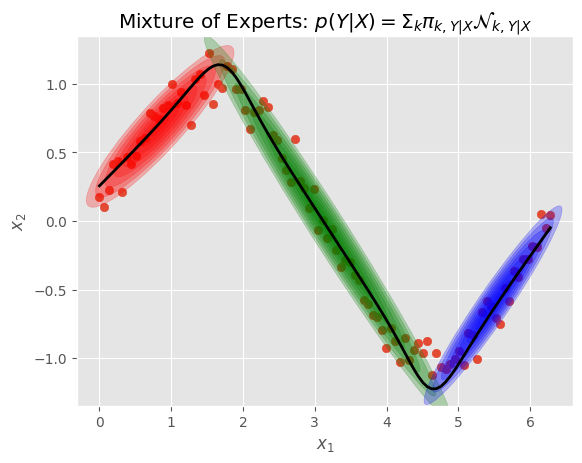

In [6]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    ax.set_title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
              "\mathcal{N}_{k, Y|X}$")
    ax.scatter(X[:, 0], X[:, 1])
    plot_error_ellipses(ax, gmm, colors=["r", "g", "b"])
    ax.plot(X_test, Y.ravel(), c="k", lw=2)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    plt.show()

## Learn Time-Indexed Trajectories

We learn a GMM from multiple similar trajectories that consist of points
$(t, x_1, x_2)$, where t is a time variable and $x_1$ and $x_2$ are 2D coordinates.
The GMM is initialized from a Bayesian GMM of sklearn to get a better fit
of the data, which is otherwise difficult in this case, where we have discrete
steps in the time dimension and $x_1$.

We compare the $95\%$ confidence interval in $x_2$ between the original data and
the learned GMM.

In [7]:
def make_demonstrations(n_demonstrations, n_steps, sigma=0.25, mu=0.5,
                        start=np.zeros(2), goal=np.ones(2), random_state=None):
    """Generates demonstration that can be used to test imitation learning.

    Parameters
    ----------
    n_demonstrations : int
        Number of noisy demonstrations

    n_steps : int
        Number of time steps

    sigma : float, optional (default: 0.25)
        Standard deviation of noisy component

    mu : float, optional (default: 0.5)
        Mean of noisy component

    start : array, shape (2,), optional (default: 0s)
        Initial position

    goal : array, shape (2,), optional (default: 1s)
        Final position

    random_state : int
        Seed for random number generator

    Returns
    -------
    X : array, shape (n_task_dims, n_steps, n_demonstrations)
        Noisy demonstrated trajectories

    ground_truth : array, shape (n_task_dims, n_steps)
        Original trajectory
    """
    random_state = np.random.RandomState(random_state)

    X = np.empty((2, n_steps, n_demonstrations))

    # Generate ground-truth for plotting
    ground_truth = np.empty((2, n_steps))
    T = np.linspace(-0, 1, n_steps)
    ground_truth[0] = T
    ground_truth[1] = (T / 20 + 1 / (sigma * np.sqrt(2 * np.pi)) *
                       np.exp(-0.5 * ((T - mu) / sigma) ** 2))

    # Generate trajectories
    for i in range(n_demonstrations):
        noisy_sigma = sigma * random_state.normal(1.0, 0.1)
        noisy_mu = mu * random_state.normal(1.0, 0.1)
        X[0, :, i] = T
        X[1, :, i] = T + (1 / (noisy_sigma * np.sqrt(2 * np.pi)) *
                          np.exp(-0.5 * ((T - noisy_mu) /
                                         noisy_sigma) ** 2))

    # Spatial alignment
    current_start = ground_truth[:, 0]
    current_goal = ground_truth[:, -1]
    current_amplitude = current_goal - current_start
    amplitude = goal - start
    ground_truth = ((ground_truth.T - current_start) * amplitude /
                    current_amplitude + start).T

    for demo_idx in range(n_demonstrations):
        current_start = X[:, 0, demo_idx]
        current_goal = X[:, -1, demo_idx]
        current_amplitude = current_goal - current_start
        X[:, :, demo_idx] = ((X[:, :, demo_idx].T - current_start) *
                             amplitude / current_amplitude + start).T

    return X, ground_truth

In [48]:
plot_covariances = True
X, _ = make_demonstrations(
    n_demonstrations=10, n_steps=50, goal=np.array([1., 2.]),
    random_state=0)
X = X.transpose(2, 1, 0)
steps = X[:, :, 0].mean(axis=0)
expected_mean = X[:, :, 1].mean(axis=0)
expected_std = X[:, :, 1].std(axis=0)

n_demonstrations, n_steps, n_task_dims = X.shape
X_train = np.empty((n_demonstrations, n_steps, n_task_dims + 1))
X_train[:, :, 1:] = X
t = np.linspace(0, 1, n_steps)
X_train[:, :, 0] = t
X_train = X_train.reshape(n_demonstrations * n_steps, n_task_dims + 1)

random_state = check_random_state(0)
n_components = 4
initial_means = kmeansplusplus_initialization(X_train, n_components, random_state)
initial_covs = covariance_initialization(X_train, n_components)
bgmm = BayesianGaussianMixture(n_components=n_components, max_iter=100).fit(X_train)
gmm = GMM(
    n_components=n_components,
    priors=bgmm.weights_,
    means=bgmm.means_,
    covariances=bgmm.covariances_,
    random_state=random_state)
# gmixt = GaussianMixture(n_components=n_components, max_iter=100).fit(X_train)
# gmm = GMM(
#     n_components=n_components,
#     priors=gmixt.weights_,
#     means=gmixt.means_,
#     covariances=gmixt.covariances_,
#     random_state=random_state)

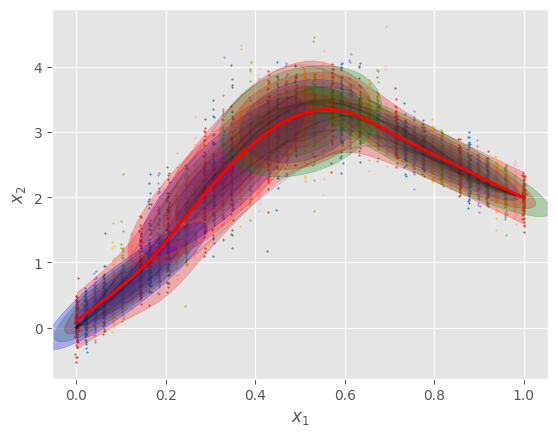

In [49]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()

    # Trajectories data
    ax.plot(X[:, :, 0].T, X[:, :, 1].T, c="k", alpha=0.1)
    
    means_over_time = []
    y_stds = []
    for step in t:
        conditional_gmm = gmm.condition([0], np.array([step]))
        conditional_mvn = conditional_gmm.to_mvn()
        means_over_time.append(conditional_mvn.mean)
        y_stds.append(np.sqrt(conditional_mvn.covariance[1, 1]))
        samples = conditional_gmm.sample(100)
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
    means_over_time = np.array(means_over_time)
    y_stds = np.array(y_stds)
    
    ax.plot(means_over_time[:, 0], means_over_time[:, 1], c="r", lw=2)
    ax.fill_between(
        means_over_time[:, 0],
        means_over_time[:, 1] - 1.96 * y_stds,
        means_over_time[:, 1] + 1.96 * y_stds,
        color="r", alpha=0.25)
    
    if plot_covariances:
        colors = cycle(["r", "g", "b"])
        for factor in np.linspace(0.5, 4.0, 8):
            new_gmm = GMM(
                n_components=len(gmm.means), priors=gmm.priors,
                means=gmm.means[:, 1:], covariances=gmm.covariances[:, 1:, 1:],
                random_state=gmm.random_state)
            for mean, (angle, width, height) in new_gmm.to_ellipses(factor):
                ell = Ellipse(xy=mean, width=width, height=height,
                                angle=np.degrees(angle))
                ell.set_alpha(0.25)
                ell.set_color(next(colors))
                ax.add_artist(ell)
    
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    plt.show()

In [34]:
conditional_gmm.means.shape, conditional_mvn.mean.shape

((4, 2), (2,))

In [10]:
# with plt.style.context("ggplot"):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.title("Confidence Interval from GMM")
    
#     plt.plot(X[:, :, 0].T, X[:, :, 1].T, c="k", alpha=0.1)
    
#     means_over_time = []
#     y_stds = []
#     for step in t:
#         conditional_gmm = gmm.condition([0], np.array([step]))
#         conditional_mvn = conditional_gmm.to_mvn()
#         means_over_time.append(conditional_mvn.mean)
#         y_stds.append(np.sqrt(conditional_mvn.covariance[1, 1]))
#         samples = conditional_gmm.sample(100)
#         plt.scatter(samples[:, 0], samples[:, 1], s=1)
#     means_over_time = np.array(means_over_time)
#     y_stds = np.array(y_stds)
    
#     plt.plot(means_over_time[:, 0], means_over_time[:, 1], c="r", lw=2)
#     plt.fill_between(
#         means_over_time[:, 0],
#         means_over_time[:, 1] - 1.96 * y_stds,
#         means_over_time[:, 1] + 1.96 * y_stds,
#         color="r", alpha=0.25)

#     plt.gca().set_ylim(-1.0, 6.0)
    
#     if plot_covariances:
#         colors = cycle(["r", "g", "b"])
#         for factor in np.linspace(0.5, 4.0, 8):
#             new_gmm = GMM(
#                 n_components=len(gmm.means), priors=gmm.priors,
#                 means=gmm.means[:, 1:], covariances=gmm.covariances[:, 1:, 1:],
#                 random_state=gmm.random_state)
#             for mean, (angle, width, height) in new_gmm.to_ellipses(factor):
#                 ell = Ellipse(xy=mean, width=width, height=height,
#                                 angle=np.degrees(angle))
#                 ell.set_alpha(0.15)
#                 ell.set_color(next(colors))
#                 plt.gca().add_artist(ell)
    
#     plt.xlabel("$x_1$")
#     plt.ylabel("$x_2$")
    
#     plt.subplot(122)
#     plt.title("Confidence Interval from Raw Data")
#     plt.plot(X[:, :, 0].T, X[:, :, 1].T, c="k", alpha=0.1)
    
#     plt.plot(steps, expected_mean, c="r", lw=2)
#     plt.fill_between(
#         steps,
#         expected_mean - 1.96 * expected_std,
#         expected_mean + 1.96 * expected_std,
#         color="r", alpha=0.5)
    
#     plt.xlabel("$x_1$")
#     plt.ylabel("$x_2$")
#     plt.gca().set_ylim(-1.0, 6.0)
    
#     plt.show()

## ProMP

In [51]:
X.shape

(10, 50, 2)

In [53]:
steps.shape

(50,)

## GMMX

In [11]:
key = jax.random.PRNGKey(123)

In [12]:
n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
X[:, 1] = np.sin(X[:, 0]) + random_state.randn(n_samples) * 0.1

In [13]:
# Create a Gaussian Mixture Model with 16 components and 32 features
gmm = GaussianMixtureModelJax.create(n_components=3, n_features=2)

# # Draw samples from the model
# n_samples = 10_000
# x = gmm.sample(key=key, n_samples=n_samples)

# Fit the model to the data
em_fitter = EMFitter(tol=1e-3, max_iter=100)
gmm_fitted = em_fitter.fit(x=X, gmm=gmm)

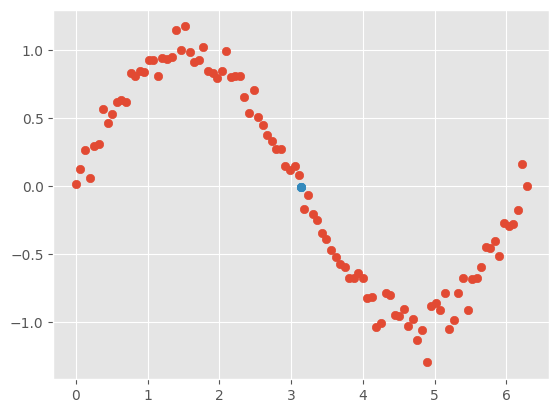

In [14]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(gmm_fitted.gmm.means.squeeze()[:, 0], gmm_fitted.gmm.means.squeeze()[:, 1])
    plt.show()

In [15]:
gmm_fitted.gmm.means

Array([[[[ 3.1415932 ],
         [-0.00493106]],

        [[ 3.1415932 ],
         [-0.00493106]],

        [[ 3.1415932 ],
         [-0.00493106]]]], dtype=float32)

In [16]:
def plot_gmm(ax, weights, means, covariances, **kwargs):
    """Plot a GMM"""
    x = np.linspace(-5, 15, 1000)
    y = np.zeros_like(x)

    for w, m, c in zip(weights, means, covariances):
        y += w * norm.pdf(x, m, np.sqrt(c))

    ax.plot(x, y, **kwargs)